# Parte 1: Estudio comparativo de PE usando características locales

## Introdución
En este notebook, se muestran las métricas obtenidas para los diferentes modelos propuestos. Mediante el dataset Household Power Consumption del portal UCI (https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption), estudiaremos la utilidad de cada uno de los mecanismos, y estableceremos cuál es el mecanismo a usar con otros datasets del estado del arte. El objetivo es estudiar el impacto de diferentes estrategias de encoding para ver cuál nos permite obtener mejores resultados en secuencias de larga extensión.

Examinaremos las siguientes alternativas:

| Codificación             | Descripción                                                       |
|-------------------|------------------------------------------------------------------|
| `no_pe`           | Sin codificación posicional, se usan solo los datos de entrada.      |
| `informer`        | Codificación temporal original de Informer.|
| `stats`           | Codificación basada en estadísticas por ventana temporal deslizante, que calcula media, std y valores extremos.        |
| `stats_lags`      | Igual que `stats`, pero incluye lags como contexto local.    |
| `all_pe_weighted` | Combinación de lo anterior, junto a PE fijos y PE aprendibles (LPE), ponderados con pesos normalizados mediante Softmax.   |
| `tpe`             | Codificación temporal haciendo uso de temporal PE, t-PE, para aportar mayor información local. Contiene la información de lags, ventana y otros PE fijos, haciendo uso de pesos aprendidos y normalizados mediante Softmax. |
| `spe`|Alteración del mecanismo de atención para incorporar información estadística sin necesidad de incrustarla en el embedding.|

Tras dichas pruebas, examinaremos la mejor alternativa en base a las métricas y el costo computacional, y probaremos a experimentar si realmente la información añadida tiene impacto en la calidad de los resultados realizando Shuffle del contexto de entrada del encoder en test.

## Positional encodings empleados

Para comprender de manera fundamentada las alternativas propuestas anteriormente, podemos analizar nuestro punto de partida, Informer, y dos de las propuestas tomadas del paper de Habib Irani y Vangelis Metsis (https://arxiv.org/pdf/2502.12370): TPE y SPE.

### Informer: modelo de partida

Es el PE propuesto originalmente por Vaswani et al. (2017). Utiliza funciones sinusoidales para representar la posición:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

Donde cada variable indica:

- **pos**: índice temporal (posición).
- **i**: dimensión del componente del embedding.
- **d**: dimensión total del embedding.

Basándonos simplemente en su formulación, podemos distinguir ya sus ventajas y desventajas. Como ventaja, podemos ver que se trata de una codificación no entrenable, por lo que para unas mismas dimensiones de entrada de datos, el resultado será siempre el mismo, y sus valores no se deben entrenar época a época de manera independiente. Esto lo hace más sencillo de usar, y más eficiente al no requerir parámetros adicionales. Sin embargo, como principal desventaja, estimamos que no permite modelar con suficiente adaptabilidad los períodos no estacionales de datos o con mayor número de irregularidades y valores anómalos.


### Codificación Posicional Aprendible: Learnable PE (LPE)

En este otro enfoque, en lugar de fijar de antemano la codificación, como en la versión tradicional, establecemos que los parámetros son aprendibles por el modelo, y por tanto, requerirán ser ajustados durante las diferentes épocas, aumentando así la complejidad del modelo, pero permitiendo una mayor adaptabilidad a la forma de los datos de entrada.

$$
PE_{\text{learnable}}(pos) = W_{pos}, \quad W_{pos} \in \mathbb{R}^d
$$

Se incorpora al embedding original de entrada de manera aditiva.

$$
X' = X + PE_{\text{learnable}}[pos]
$$

Por tanto, las principales ventajas son la adaptabilidad al conjunto de datos de entrada, la posibilidad de que el propio modelo ajuste los pesos sin necesidad de realizarlo de manera fija e inflexible. Pero, como es notable en su definición, estamos aumentando el número de parámetros necesarios del modelo, por lo que supondrá un coste más elevado de entrenamiento, y además, a diferencia de los senos/cosenos, será necesario reentrenar la estructura de encoding si los datos de entrada tienen las mismas dimensiones pero distinto contenido, ya que la codificación ha de adaptarse a la forma de estos para minimizar el error.


### Codificación Posicional Temporal (T-PE)

Esta codificación está basada en el tradicional seno-coseno, que agrega la ya mencionada información global y geométrica a los datos, pero además, para mejorar la adaptabilidad a los datos, incorpora información semántica de estos. Para ello, utiliza una función de suavizado gaussiano para tratar de encontrar correspondecia entre cada par de posiciones i-j, de manera que se añada información de semejanza entre las posiciones.


$$
PE_{i, 2k} = \sin\left(\frac{i}{10000^{\frac{2k}{d}}}\right), \quad
PE_{i, 2k+1} = \cos\left(\frac{i}{10000^{\frac{2k}{d}}}\right)
$$

Y para la información local:

$$S(i, j) = \exp\left( -\frac{\|x_i - x_j\|^2}{2\sigma^2} \right)$$

Añadiéndose al encoding final de manera aditiva:

$$T\text{-}PE(i) = PE(i) + S(i, j)$$

En resumen, conserva la sencillez de un encoding tradicional, pero con la determinación de similaridad entre posiciones.


SPE (Stochastic Positional Encoding) introduce aleatoriedad controlada para mejorar la generalización y la captación de dependencias relativas.

### Generación Estocástica Posicional 

SPE es un PE que, a diferencia de los anteriores, que bastaba con sumarlos con la información base del embedding, requieren modificar el mecanismo de atención para su correcto aprendizaje. Comienza con una matriz aleatoria con entradas gaussianas estándar i.i.d.:

$$
Z_d \in \mathbb{R}^{M \times R}
$$

Luego, aplica convoluciones para generar las codificaciones:

$$
Q_d = Z_d \otimes \Phi_Q, \quad K_d = Z_d \otimes \Phi_K
$$

donde:
- **$\otimes$** representa la operación de convolución.
- **( $\Phi_Q, \Phi_K$)** son filtros convolucionales aprendibles.

La atención se calcula como:

$$
P_d \approx \frac{\bar{Q}_d \bar{K}_d^\top}{R}
$$

Este producto aproximado retiene relaciones posicionales mediante convoluciones, y añade complejidad lineal que depende de la longitud de la secuencia.

Sobre el papel, presenta varias ventajas:
- Captura relaciones relativas sin requerir atención cuadrática.
- Permite una mayor escalabilidad gracias a su menor costo computacional
- Es más robusta ante sobreajuste por su componente estocástico, y podría ser eficaz en clasificación de series temporales largas y multivariadas.

Sin embargo, aunque teóricamente pueda parecer más eficiente, modificar el mecanismo de atención puede ser crítico en función del conjunto de datos, ya que al no depender de estos, la codificación podría ser demasiado agnóstica del contexto, y ofrecer peores resultados.

Una vez explicadas los modelos, pasaremos a probarlo sobre el conjunto de datos HPC, tomando como baseline el modelo Informer sin ningún tipo de encoding, es decir, empleando únicamente para la construcción del embedding la información proporcionada directamente por los datos.

## Evaluación de los 7 modelos de PE mediante HPC

Comenzaremos experimentando primero cuál de las 7 alternativas propuestas permite obtener un mejor resultados. En muchas de ellas, como ya se comentaba, se utilizan diversas estrategias de encoding ponderadas, ya que así el modelo puede decidir cuál de ellas es la que mejor se adapta al problema. Esto se debe a que, en ocasiones, la coexistencia de varios métodos no tiene por qué empeorar el resultado, ya que cada problema requiere unas necesidades específicas, en función de la correlación de los datos, y no existe una codificación de PE absoluta mejor en todos los casos.

A continuación, procederemos a la lectura de los ficheros csv que contienen los resultados, y compararemos tanto en tabla como gráficamente sus resultados. Nos fijaremos especialmente en MAE Y MSE, recurriendo al resto de métricas cuando no exista una diferencia clara.

Para tratar de no favorecer algoritmos concretos, todos serán evaluados siguiendo los parámetros aquí reflejados:

- Ventana: 60
- Longitud de secuencia: 180
- Longitud de contexto: 60
- Longitud de predicción: 60 

### Comparativa


In [76]:
import pandas as pd

# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/HPC_ALL_PE_v2.csv",
    "No PE": "Experimentos/HPC_No_PE.csv",
    "PE (sin/cos)": "Experimentos/metricas_InformerVanilla_hpc_pe_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebfixed_dtTrue_mxTrue_test_hpc_pe.csv",
    #"ALL_PE_Weighted (No Norm)": "Experimentos/HPC_ALL_PE_v2_NoNorm.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_hpc_informer_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer.csv",
    "Informer SPE": "Experimentos/HPC_SPE.csv",
    "WinStatSPE": "Experimentos/HPC_SPE_ALL.csv",
    "WinStat": "Experimentos/metricas_InformerVanilla_stats_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_stats.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_tpe_weighted_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted.csv",
    "WinStatLag": "Experimentos/HPC_Ventana_Lags.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    # print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostrar
display(final_df)

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,WinStatFlex,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
7,WinStatTPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
8,WinStatLag,0.398612,2.312104,0.491026,1012.281759,0.700723,229.312370,13071.568639,0.005025,0.086223,0.004988,108.017980,0.003566,3.086725,1403.397188
6,WinStat,0.394002,2.487715,0.502033,1196.131307,0.708535,253.980487,17697.790107,0.002849,0.090071,0.004632,105.107660,0.003274,3.765932,3174.414850
3,Informer,0.415272,2.598725,0.532965,1345.903158,0.730005,91.941244,7817.020260,0.012216,0.066858,0.010976,113.730710,0.007540,1.244423,821.270911
2,PE (sin/cos),0.414084,2.573043,0.537721,1363.108439,0.733254,225.145923,10741.035530,0.006756,0.094281,0.011375,117.156140,0.007743,63.836650,422.837205
1,No PE,0.421343,2.394682,0.544844,1053.862630,0.738126,125.053827,10382.266527,0.005856,0.055825,0.005447,84.204210,0.003690,2.833062,2083.316310
4,Informer SPE,0.417545,2.518025,0.553648,1348.892415,0.743617,1461.875124,111056.220972,0.019881,0.027908,0.039257,75.910977,0.026116,NaN,NaN
5,WinStatSPE,0.441418,2.558296,0.582600,1388.203491,0.762703,1730.330627,131450.338871,0.032406,0.121722,0.044727,147.022305,0.029725,NaN,NaN


Podemos apreciar que el modelo con mejor rendimiento es el basado en varios encodings posicionales los cuales han sido normalizados y ponderados con pesos entre 0 y 1 mediante SoftMax. Son los que mejores resultados ofrecen en MSE, pero también está dentro del top cuando observamos MAE o RMSE, pero ahí si existen leves mejoras en otros modelos. Sin embargo, dado a la cercanía de estas otras alternativas, y a su mayor coste computacional, podríamos considerar que el modelo propuesto en la primera fila es aquel que debemos comparar y verificar con respecto al modelo original.

Para ver los resultados de forma gráfica, podemos representar los valores de MSE y MAE en un gráfico de barras.

In [77]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 11})  


import numpy as np
import matplotlib.pyplot as plt

def plot_metricas_con_error(df,
                            modelos_col='Modelo',
                            metricas=['MAE_Mean', 'MSE_Mean'],
                            stds=['MAE_STD', 'MSE_STD'],
                            titulo='Comparación de métricas por modelo con desviación estándar'):
    """
    Genera un gráfico de barras con barras de error (desviación estándar) usando granate claro y oscuro.
    Además coloca etiquetas numéricas en notación científica sobre cada barra, con el mismo color de la barra.
    """
    # Copiar solo las columnas necesarias
    df_plot = df[[modelos_col] + metricas + stds].copy()

    # Reemplazar NaNs en std por 0
    for std_col in stds:
        df_plot[std_col] = df_plot[std_col].fillna(0)

    # Configuración de posiciones
    x = df_plot[modelos_col]
    x_pos = np.arange(len(x))
    width = 0.35

    # Colores granate de tab20
    colores = ["steelblue", "orange"]  # oscuro, claro

    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))

    # Dibujar cada barra de métrica
    for i, (metrica, std) in enumerate(zip(metricas, stds)):
        offset = (-1)**i * width / 2  # alternar izquierda/derecha
        color = colores[i % len(colores)]  # asignar color granate
        bars = ax.bar(x_pos + offset,
                      df_plot[metrica],
                      width=width,
                      yerr=df_plot[std],
                      capsize=5,
                      label=metrica.replace('_Mean', ''),
                      color=color)

        # Añadir etiquetas numéricas en notación científica
        for xpos, val, bar in zip(x_pos, df_plot[metrica].values, bars):
            bar_color = bar.get_facecolor()
            ax.text(xpos + offset,
                    val * 1.05,       # un poco por encima
                    f"{val:.2e}",     # notación científica
                    ha='center', va='bottom',
                    fontsize=10.75
                   )

    # Etiquetas
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.set_ylabel('Valor')
    ax.set_title(titulo)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{titulo}.png")
    plt.show()



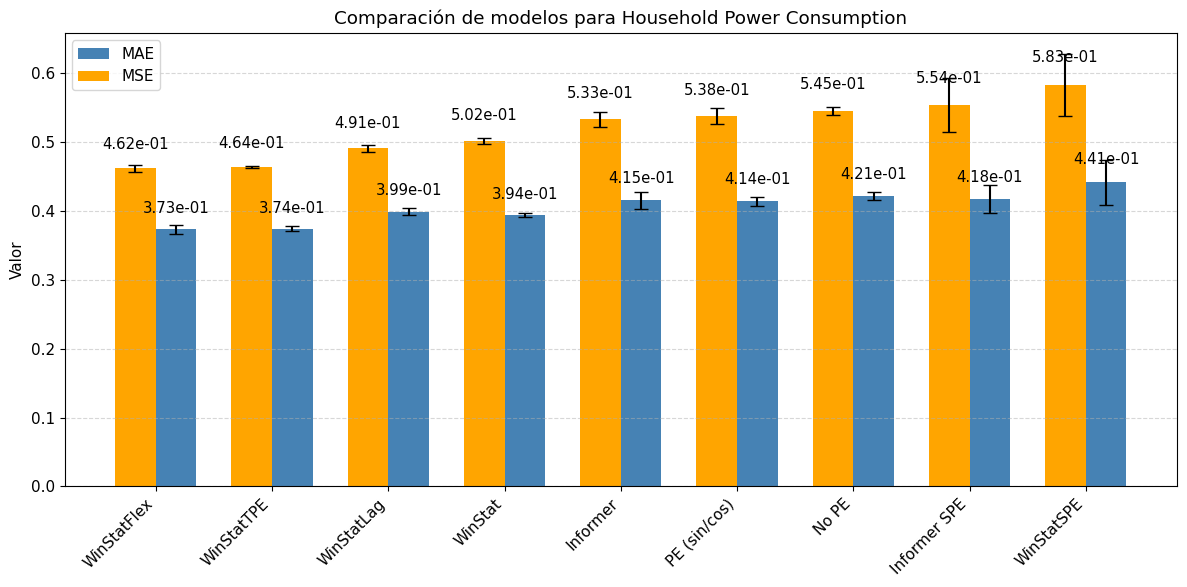

In [78]:
# Mostramos métricas para HPC
plot_metricas_con_error(final_df, titulo="Comparación de modelos para Household Power Consumption")

### Barajando los mejores modelos

Una vez seleccionado el modelo que queremos comprobar, podemos pasar a ejecutar un experimento: comprobar si el positional encoding está realmente ayudando a aportar valor al modelo. Para ello, podemos realizar un pequeño experimento en el cual, mezclar los valores de entrada de referencia para el decoder, y ver si así se obtienen resultados similares a introducirlos originales.

Lo que buscamos es ver si la información añadida por el PE realmente ayuda al modelo a aprender información local, o si por consiguiente, se está desaprovechando cómputo a cambio leves mejoras o incluso empeoramiento.

Al igual que en el apartado anterior, procederemos a la lectura de resultados de 4 modelos:
- Estadísticos + lags original
- Estadísticos + lags desordenado
- Informer original
- Informer desordenado


,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,WinStatFlex,0.373488,2.251120,0.461892,986.080587,0.679617,350.836037,18652.724426,0.006858,0.091233,0.004841,128.446180,0.003558,5.567514,128.342962
5,WinStatTPE,0.374392,2.252478,0.463651,954.171082,0.680918,296.252991,18913.633506,0.004132,0.001750,0.001917,38.396774,0.001408,1.955109,28.792701
2,Informer,0.415272,2.598725,0.532965,1345.903158,0.730005,91.941244,7817.020260,0.012216,0.066858,0.010976,113.730710,0.007540,1.244423,821.270911
4,No PE,0.421343,2.394682,0.544844,1053.862630,0.738126,125.053827,10382.266527,0.005856,0.055825,0.005447,84.204210,0.003690,2.833062,2083.316310
3,Informer (Shuf.),0.419960,2.637963,0.548443,1299.400024,0.740543,85.987744,7523.083485,0.002769,0.082234,0.009148,157.126600,0.006162,0.768127,1508.276486
1,WinStatFlex (Shuf.),0.581124,2.427627,0.782092,716.527344,0.884222,330.988508,20842.951120,0.021991,0.106249,0.027368,69.707450,0.015572,6.040981,1877.777867
6,WinStatTPE (Shuf.),0.581001,2.740639,0.851115,1022.612895,0.922467,295.005139,20580.513685,0.046717,0.080763,0.024083,95.225204,0.013023,1.204927,2278.562719


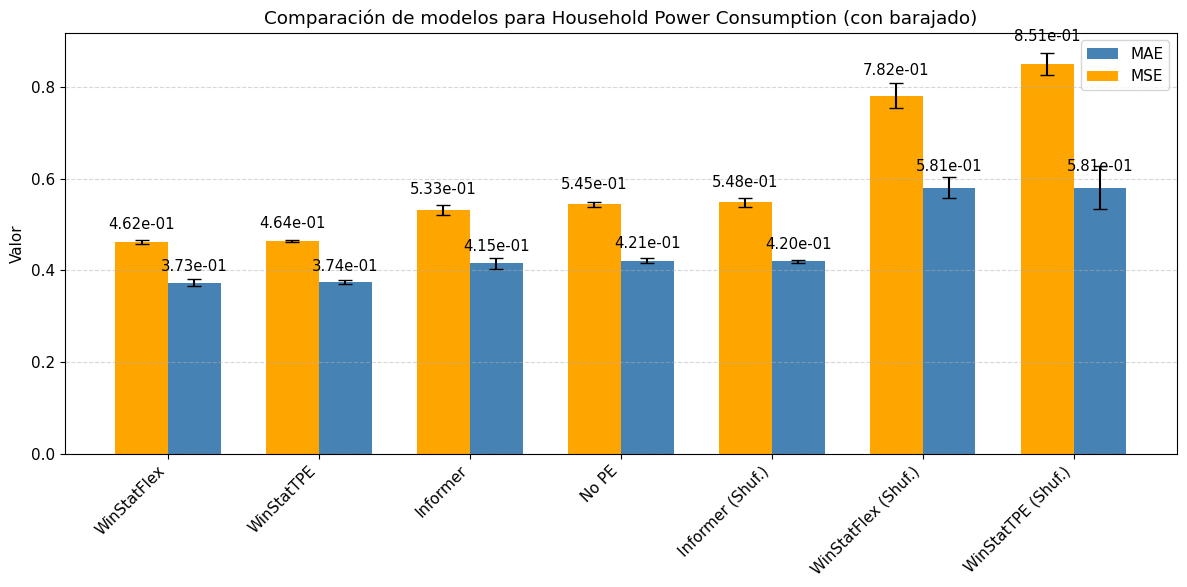

In [79]:
# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/HPC_ALL_PE_v2.csv",
    "WinStatFlex (Shuf.)": "Experimentos/HPC_ALL_PE_v2_Shuffled.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_hpc_informer_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer.csv",
    "Informer (Shuf.)": "Experimentos/metricas_InformerVanilla_hpc_informer_shuffled_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_hpc_informer_shuffled.csv",
    "No PE": "Experimentos/HPC_No_PE.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_tpe_weighted_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted.csv",
    "WinStatTPE (Shuf.)": "Experimentos/metricas_InformerVanilla_tpe_weighted_shuffled_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tpe_weighted_shuffled.csv"#,
    #"PE (Fixed)": "Experimentos/metricas_InformerVanilla_hpc_pe_informer_HPCm_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebfixed_dtTrue_mxTrue_test_hpc_pe.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico

display(final_df)
plot_metricas_con_error(final_df, titulo="Comparación de modelos para Household Power Consumption (con barajado)")

Podemos apreciar, claramente, que el impacto de mezclar la información de referencia en el encoder afecta de manera considerable a la alternativa que usa ventana de estadísticos, ya que se está rompiendo considerablemente la estructura temporal de los datos. Es un resultado razonable, pues mezclar la información dentro de las ventanas está alterando gravemente la información contenida localmente.

Sin embargo, cuando realizamos el mismo procedimiento con el modelo Informer original, la diferencia es muy poco notable: pasamos apenas de 0.532 de MSE a 0.548. En el caso de las alternativas basadas en estadísticos, se pasa de 0.46 a 0.78, reflejando un empeoramiento significativo en los resultados a diferencia del modelo original.

También se ha evaluado el modelo basado en TPE, debido a su menor varianza y cercanía a los estadísticos. En dicho caso, pasamos de 0.463 a 0.85, siendo aún más notable la diferencia.

Por tanto, podríamos asumir que la información fija aportada por el PE sinusoidal de Informer no está añadiendo suficiente riqueza en datos de larga extensión como este dataset. Si bien, sí que mejora considerablemente el resultado contra un modelo sin ningún tipo de codificación (NoPe En el gráfico), la información añadida es puramente global, y en secuencias de esta longitud, podemos observar cambios de comportamiento a nivel local que pueden ser interesantes de tener en cuenta.

A primera vista, el PE propuesto en ALL_PE_Weighted podría parecer superior, ya que estamos aprovechando dicha información local de utilidad. Sin embargo, tambiém debemos tener en cuenta el encoding basado en TPE, pues ofrece resultados también muy competitivos, y en otros datasets, podría ofrecer un buen resultado, ya que parece ser más estable en sucesivas ejecuciones (menor varianza), y tiene una inferencia más eficiente en tiempo. 

Por lo tanto, será también evaluado con el resto de datasets restantes, debido a que las diferencias en HPC han sido prácticamente marginales.

## Evaluación mediante otros datasets

Una vez definidos los encodings a probar, `TPE` y `All_PE_Weighted`, procederemos a evaluar el rendimiento sobre otros 3 datasets conocidos en el estado del arte:
- **ETTh1**, el dataset de funcionamiento de un sistema eléctrico referenciado en el paper original de Informer, y el cual fue usado para su análisis de rendimiento.
- **Yellow Tripdata**, un conjunto de datos que recopila información acerca de viajes en taxi y su coste asociado. Resulta de interés debido a su posible estacionalidad en horas nocturnas y fines de semana, donde los precios son mayores, e identificar otros patrones (por ejemplo, hora de entrada y salida laboral, etc.). En adelante, para mayor comodidad, lo referenciaremos como `Taxi`.
- **TINA**, cuyo acrónimo proviene de Time-series Industrial Anomaly, donde la gran tarea de interés reside en la detección anomalías y patrones en las mismas.

### ETTh1

Comenzaremos por el dataset de menor tamaño, ETT, el cual es ampliamente utilizado en el estado del arte para la comparativa entre nuevos modelos. Aunque su extensión es bastante reducida, nos permitirá ver el rendimiento del modelo que estamos proponiendo en otro tipo de series, y ver si es lo suficientemente elástico como para adaptarse a diferentes características.

La configuración usada será la misma que en el paper original de Informer para establecer las mismas condiciones. En cuanto a la configuración de la ventana, cuando corresponde, y la longitud de la predicción, se ha establecido:

- Ventana: 24
- Longitud de secuencia: 96
- Longitud de contexto: 48
- Longitud de predicción: 24 (1 día)

A continuación, importaremos los resultados y los graficaremos de la misma forma que el apartado anterior.

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,WinStatFlex,0.494661,10.515547,0.465990,40193.949219,0.682334,0.779390,27.822449,0.019507,0.347335,0.027734,2941.5654,0.020266,0.008920,2.565389
5,WinStatTPE,0.507179,11.085088,0.489647,45770.907813,0.698881,1.339969,52.732013,0.031240,0.730064,0.048151,7129.3390,0.034805,0.043272,0.954233
2,Informer,0.532375,11.799151,0.545807,48779.951562,0.738659,0.383596,16.819558,0.017099,1.626443,0.020421,13908.2080,0.013775,0.002506,1.748976
3,PE (sin/cos),0.555214,11.869595,0.577572,47931.058203,0.758369,0.607528,25.520506,0.053092,1.172958,0.075510,10247.6900,0.049472,0.003783,0.385055
1,WinStatFlex (Shuf.),0.631257,10.456927,0.689675,36663.685937,0.829999,0.799599,27.664155,0.027637,0.794871,0.046108,6098.2670,0.027873,0.007132,0.196630
6,WinStatTPE (Shuf.),0.672846,11.246408,0.803575,42832.119531,0.895662,1.408538,58.641512,0.035790,1.498342,0.066685,12783.6790,0.036937,0.085056,6.365417
4,No PE,0.741918,14.232987,0.923467,76807.512109,0.960007,0.451098,17.335851,0.050922,4.295049,0.084128,46287.2800,0.043059,0.043514,3.149851


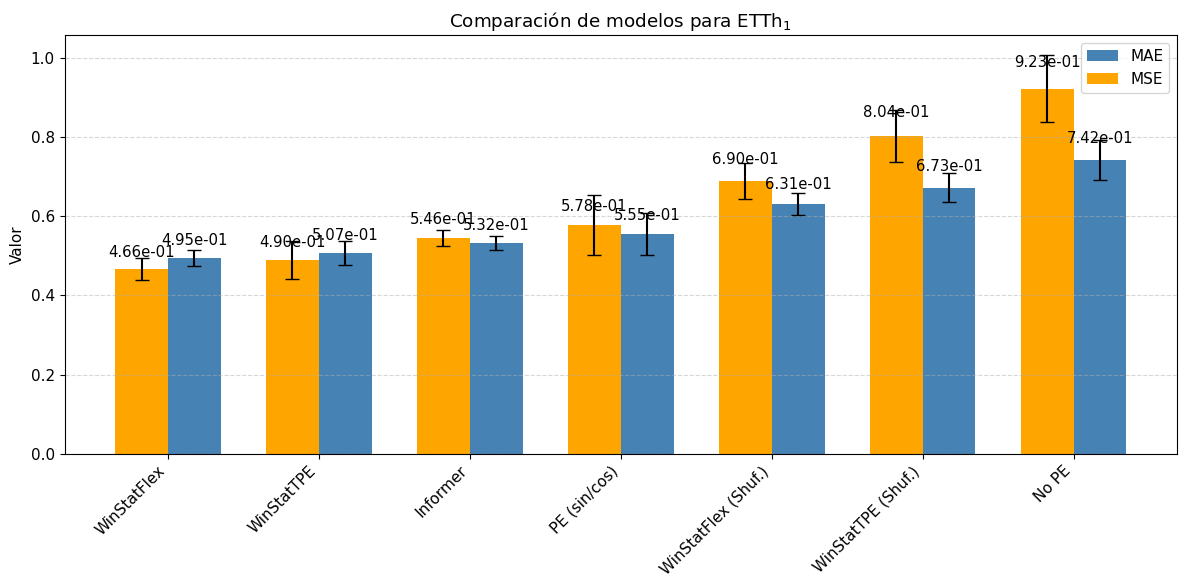

In [80]:
# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/metricas_InformerVanilla_etth1_all_pe_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_all_pe.csv",
    "WinStatFlex (Shuf.)": "Experimentos/metricas_InformerVanilla_etth1_all_pe_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_all_pe_shuffled.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_etth1_informer_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_informer.csv",
    "PE (sin/cos)": "Experimentos/metricas_InformerVanilla_etth1_fixed_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el3_dl2_df2048_atfull_fc5_ebfixed_dtTrue_mxTrue_test_etth1_fixed.csv",
    "No PE": "Experimentos/metricas_InformerVanilla_etth1_nope_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_nope.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_etth1_tpe_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe.csv",
    "WinStatTPE (Shuf.)": "Experimentos/metricas_InformerVanilla_etth1_tpe_shuffled_informer_ETTh1_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_etth1_tpe_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo=f"Comparación de modelos para ETTh$_1$")

Podemos apreciar resultados muy diferentes a los vistos para una secuencia más larga:

- El rendimiento de All_PE siguen siendo el ganador, pero esta vez, con mayor diferencia, siendo esta vez de 0.04, que es 40 veces mayor a la diferencia existente en HPC. Además, la varianza de TPE es ahora mayor a la de ALL_PE, tal y como se puede verificar tanto numéricamente como en la barra de error.
- El rendimiento de Informer, curiosamente, parece ser más cercano en este conjunto. Podemos ver que, además, cuando realizamos el mezclado, ahora es el modelo de Informer el que más impacto aprecia en sus resultados. De alguna manera, para secuencias más cortas, una simple codificación sinusoidal parece codificar adecuadamente la información.
- En el caso de los dos modelos propuestos, pero mezclados, el empeoramiento sigue siendo notable como hasta ahora.

Por tanto, este apartado nos arroja un resultado bastante interesante, y es que todo apunta que, a secuencias más largas, y de mayor complejidad, el PE tradicional basado en senos y cosenos tiene grandes carencias, potencialmente por la falta de aprovechamiento de la localidad, ya que series de gran tamaño podemos encontrar diferentes subsecuencias a las que debemos adaptarnos. Pero, cuando la serie es más corta, como esta, dicha información podría no ser tan variable, y de ahí que un enfoque global como Informer puedea seguir manteniendose cercano a los mecanismos locales.

También podríamos sumar el impacto de la profundidad de las arquitecturas y estructuras de datos: a mayor tamaño de entrada, mayor número de parámetros, y por ende, más dificultad de propagación del aprendizaje del encoding a través de la arqutectura. Sin embargo, para verificarlo, debemos seguir evaluando más datasets.

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
0,WinStatFlex,0.512808,3.343877,0.467676,1530.202856,0.679749,0.834729,32.989481,0.065133,0.767829,0.101775,410.78955,0.074946,0.024313,3.775380
5,WinStatTPE,0.588919,4.052313,0.596380,1707.383569,0.770738,1.327944,54.832880,0.049605,0.355036,0.076012,527.47955,0.048395,0.068589,4.593619
6,WinStatTPE (Shuf.),0.689227,3.028018,0.829357,996.215570,0.906931,1.296295,61.370783,0.071371,1.000848,0.141778,387.04938,0.082663,0.045580,9.487097
1,WinStatFlex (Shuf.),0.692900,3.000872,0.860800,1159.554822,0.923636,0.864139,33.118646,0.067081,0.408460,0.162531,696.41595,0.087732,0.159426,7.876129
2,Informer,0.754907,5.925552,0.886627,2924.225586,0.940080,0.449962,18.676547,0.053964,0.645586,0.100092,475.51672,0.053635,0.024086,1.945601
4,No PE,0.777736,6.796825,1.013217,4086.226156,0.998585,0.439290,18.196816,0.119947,1.558902,0.241743,447.77853,0.126672,0.049413,2.308764
3,PE (sin/cos),0.935477,3.730952,1.388127,1794.159741,1.176358,0.465952,18.290615,0.051373,0.198797,0.158151,267.39877,0.065637,0.039954,0.414452


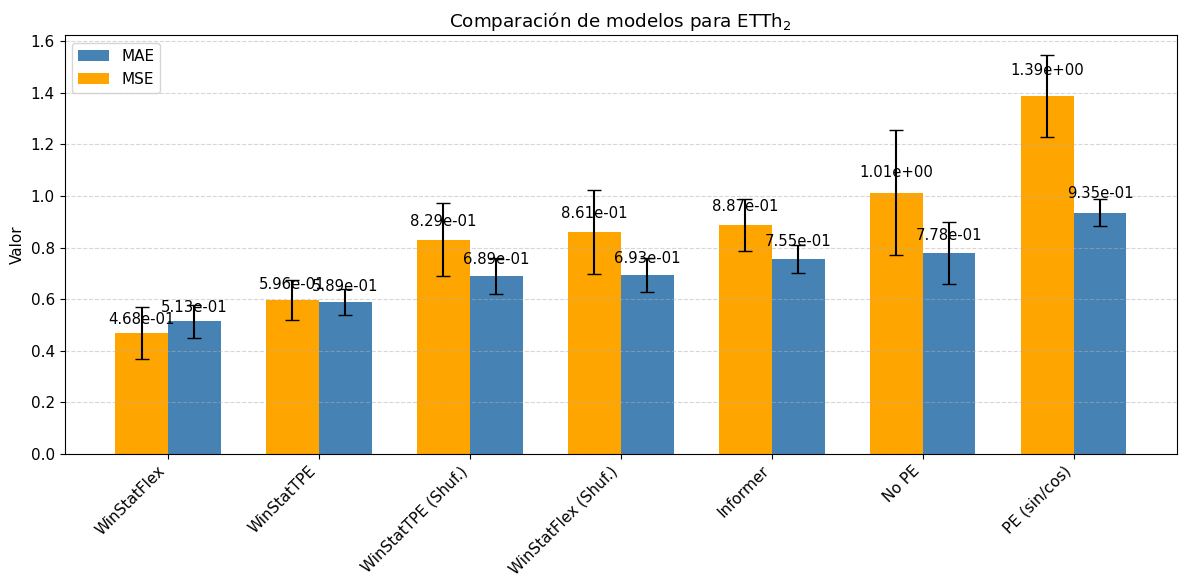

In [81]:
# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/metricas_InformerVanilla_ETTh2_new_allpe_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_new_allpe.csv",
    "WinStatFlex (Shuf.)": "Experimentos/metricas_InformerVanilla_ETTh2_all_pe_shuffled_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_all_pe_shuffled.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_ETTh2_new_informer_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_new_informer.csv",
    "PE (sin/cos)": "Experimentos/metricas_InformerVanilla_ETTh2_new_fixed_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebpe_dtTrue_mxTrue_test_ETTh2_new_fixed.csv",
    "No PE": "Experimentos/metricas_InformerVanilla_ETTh2_new_nope_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_new_nope.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_ETTh2_new_tpe_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_new_tpe.csv",
    "WinStatTPE (Shuf.)": "Experimentos/metricas_InformerVanilla_ETTh2_tpe_shuffled_informer_ETTh2_ftM_sl96_ll48_pl24_win24_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_ETTh2_tpe_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo=f"Comparación de modelos para ETTh$_2$")

### Yellow Trip Data (Taxi)

A continuación, es el turno de un dataset de extensión similar a HPC, por lo que se usarán los mismos parámetros que en este para la evaluación del rendimiento. De la misma forma, se han recopilado resultados para All_PE, TPE e Informer.

- Ventana: 60
- Longitud de secuencia: 180
- Longitud de contexto: 60
- Longitud de predicción: 60 

Para facilitar la visualización de los datos, al ser valores muy pequeños, se ha creado una función adicional que cree el gráfico de barras en dos ejes diferentes, uno para MSE y otro para MAE, ya que los valore se encuentran en el orden de 10-5.

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metricas_por_separado(df,
                               modelos_col='Modelo',
                               metricas=['MAE_Mean', 'MSE_Mean'],
                               stds=['MAE_STD', 'MSE_STD'],
                               titulos=['MAE por modelo con desviación estándar',
                                        'MSE por modelo con desviación estándar'],
                               ylim_max=None):
    """
    Genera gráficos de barras separados con barras de error (desviación estándar) para cada métrica.
    Siempre coloca el valor numérico en notación científica sobre cada barra,
    elevado un poco más, y con el mismo color que la barra.
    Si una barra excede el ylim_max, se recorta, se le coloca un símbolo de corte y se etiqueta con el valor real.
    """
    df_plot = df[[modelos_col] + metricas + stds].copy()

    # Reemplazar NaNs en std por 0
    for std_col in stds:
        df_plot[std_col] = df_plot[std_col].fillna(0)

    x = df_plot[modelos_col]
    x_pos = np.arange(len(x))
    width = 0.5
    colors = ["steelblue", "orange"]

    # Normalizamos ylim_max: puede ser None, un valor o una lista
    if isinstance(ylim_max, (int, float)):
        ylim_max = [ylim_max] * len(metricas)
    elif ylim_max is None:
        ylim_max = [None] * len(metricas)

    for i, (metrica, std, ylimit) in enumerate(zip(metricas, stds, ylim_max)):
        fig, ax = plt.subplots(figsize=(10, 5))

        # valores y errores
        valores = df_plot[metrica].values
        errores = df_plot[std].values

        bars = ax.bar(x_pos,
                      valores,
                      width=width,
                      yerr=errores,
                      capsize=5,
                      color=colors[i])

        # establecer limite en Y si corresponde
        if ylimit is not None:
            ax.set_ylim(0, ylimit)

        # añadir etiquetas a todas las barras en notación científica
        for xpos, val, bar in zip(x_pos, valores, bars):
            bar_color = bar.get_facecolor()

            if ylimit is not None and val > ylimit:
                # símbolo de corte
                ax.text(xpos, ylimit * 0.95, "//",
                        ha='center', va='top', fontsize=14, color="red", fontweight="bold")

                # valor real (arriba del límite) en notación científica
                ax.text(xpos, ylimit * 1.01, f"{val:.2e}",
                        ha='center', va='bottom', fontsize=10.75)
            else:
                # valor normal (encima de la barra) en notación científica
                ax.text(xpos, val * 1.15, f"{val:.2e}",
                        ha='center', va='bottom', fontsize=10.75)

        ax.set_xticks(x_pos)
        ax.set_xticklabels(x, rotation=45, ha='right')
        ax.set_ylabel('Valor')
        ax.set_title(titulos[i])
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.savefig(f"{titulos[i]}.png")
        plt.show()


,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
5,WinStatTPE,0.002547,0.048665,0.000010,0.012896,0.003009,415.148538,58933.194401,0.000937,0.032704,0.000005,0.015780,0.000954,2.353235,29915.678540
0,WinStatFlex,0.003529,0.038845,0.000017,0.002482,0.003964,126.929040,13785.549411,0.001027,0.013575,0.000008,0.001715,0.000970,0.241388,3977.906128
3,Informer,0.003987,0.039024,0.000019,0.001833,0.004259,82.538561,13989.064623,0.000795,0.009835,0.000007,0.001036,0.000818,5.488924,5934.676716
2,PE (sin/cos),0.004307,0.039286,0.000024,0.001740,0.004718,133.002143,15941.013716,0.001044,0.005720,0.000010,0.000301,0.001149,10.842563,4133.995509
4,No PE,0.004626,0.044944,0.000046,0.003702,0.005113,106.306432,22882.348379,0.003954,0.034260,0.000060,0.003965,0.004488,0.963729,8549.187812
6,WinStatTPE (Shuf.),0.005688,0.070109,0.000056,0.010128,0.006278,458.258713,52584.752521,0.003983,0.038019,0.000063,0.006861,0.004089,24.708775,26514.673312
1,WinStatFlex (Shuf.),0.072033,0.606673,0.130236,7.490809,0.216902,417.420240,38286.778342,0.095835,0.762853,0.183817,10.549806,0.288427,37.031800,13163.875079


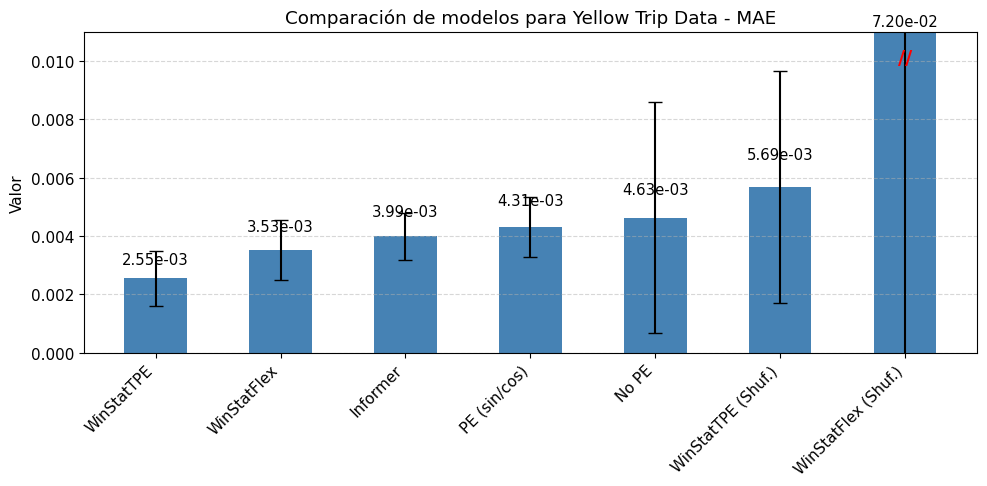

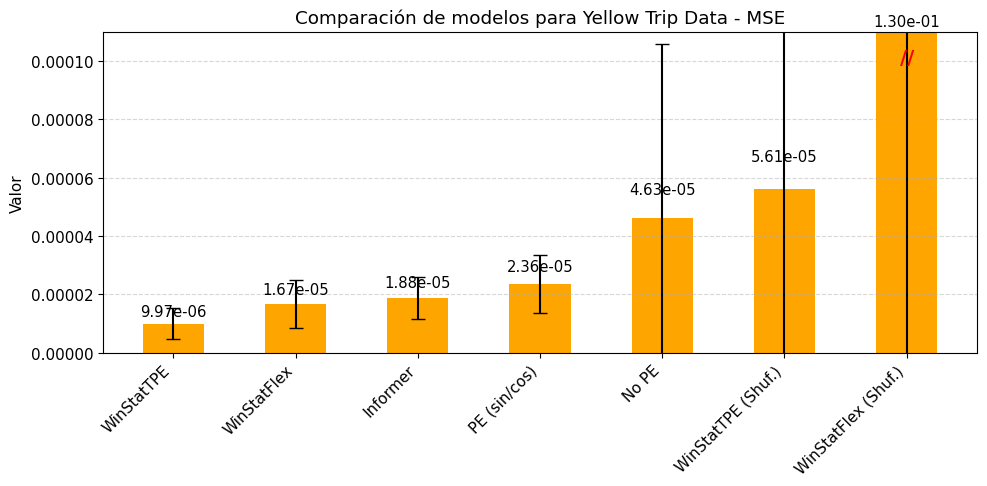

In [83]:
# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/metricas_InformerVanilla_taxi_all_pe_weighted_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_all_pe_weighted.csv",
    "WinStatFlex (Shuf.)": "Experimentos/metricas_InformerVanilla_taxi_all_pe_shuffled_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_all_pe_shuffled.csv",
    "PE (sin/cos)": "Experimentos/metricas_InformerVanilla_taxi_pe_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebfixed_dtTrue_mxTrue_test_taxi_pe.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_taxi_informer_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_informer.csv",
    "No PE": "Experimentos/metricas_InformerVanilla_taxi_nope_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_nope.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_taxi_tpe_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_tpe.csv",
    "WinStatTPE (Shuf.)": "Experimentos/metricas_InformerVanilla_taxi_tpe_shuffled_informer_Taxi_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_taxi_tpe_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)


# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_por_separado(final_df, titulos=['Comparación de modelos para Yellow Trip Data - MAE',
                                        'Comparación de modelos para Yellow Trip Data - MSE'],ylim_max=[0.011, 0.00011])

A la vista de los resultados, podemos extraer las siguientes conclusiones:

- Los resultados pueden encontrarse en una escala bastante pequeña. Esto puede deberse, o bien, a que la amplitud de los valores de la serie son bastante pequeños, o bien, que se trata de una serie fácilmente aprendible, ya sea por mantener una tendencia clara o bien una estacionalidad sencilla de modelar. Tratándose de una recopilación de datos sobre carreras de Taxi, esto segundo podría ser la principal causa, ya que los precios son mayores de noche, y además, incrementan también los fines de semana, y en media, los viajes realizados serán bastante similares. Sin embargo, se requiere el estudio de estos datos en mayor profundidad mediante EDA para asegurar.

- La mejor codificación, tanto para MAE como MSE, es la basada en TPE. Anteriormente, vimos que ofrecía valores similares a usar ALL_PE, pero en este caso, posiblemente su menor variabilidad, así como su incorporación a la tradicional fórmula sinusoidal de una componente exponencial dependiente de la información, permite tomar una mayor información local para el modelado. All_PE, sin embargo, sigue siendo una sólida alternativa, con un resultado bastante similar, aunque con prácticamente el doble de error de TPE.
- A diferencia de los datasets anteriores, el modelo original de Informer no se distancia tanto en cuanto a resultados, y ocupa la tercera posición. Si procedemos además a evaluar lo que ocurre cuando se procede a desordenar la entrada del decoder, podemos apreciar que el error se duplica, demostrando que sí es capaz de recoger parte de la infomación temporal de los datos. 
- Por último, no usar ningún tipo de codificación no aporta prácticamente ninguna ventaja, y se trata del peor caso de todos. Es además el que mayor varianza recoge en sus resultados, ya que como no se agrega información adicional a los datos, el resultado es muy dependiente de inicialización.


Por lo tanto, en este caso, podemos afirmar de manera evidente el correcto funcionamiento de TPE con respecto al resto de alternativas.

### Dataset TINA

Hasta ahora, se han ejecutado datasets de larga extensión temporal, como es el caso del anterior de Yellow Trip, o el asociado al consumo eléctrico HPC. Sin embargo, en cuanto número de variables, estos conjuntos de datos no tenían más de 7 variables. Pero, para probar la afectividad de los métodos, es necesario probar con datasets de complejidad en cuanto a variables. En este caso, TINA, cuyo conjunto de datos recopila mediciones de diferentes sensores de una acerería de ArcelorMittal (https://dasci.es/opendata/tina-time-series-industrial-anomaly-dataset/) es un buen candidato para medir la eficiencia de las codificaciones evaluadas cuando la complejidad reside sobre todo en el número de variables medidas por instante.

Quedándonos únicamente con las variables numéricas, tenemos en total 103 características a estimar mediante el modelo, por lo que dado el cambio de tipología de problema, podemos apreciar resultados bastante diferentes a los anteriores.

,Modelo,MAE_Mean,MAPE_Mean,MSE_Mean,MSPE_Mean,RMSE_Mean,TestTime(s)_Mean,TrainTime(s)_Mean,MAE_STD,MAPE_STD,MSE_STD,MSPE_STD,RMSE_STD,TestTime(s)_STD,TrainTime(s)_STD
1,Informer,0.356679,2.780652,1.096588,110744.161458,1.045978,75.916715,6437.735532,0.020001,0.213355,0.106495,41945.4380,0.050186,1.479102,1826.084507
5,WinStatTPE (Shuf.),0.454709,3.523168,1.126912,262536.346354,1.058569,382.677564,19360.338977,0.012089,0.124850,0.171745,128110.8800,0.079639,10.988814,386.610304
4,WinStatTPE,0.312652,2.544894,1.133453,49108.398700,1.063045,438.925862,35866.691845,0.021571,0.114816,0.121601,23029.2045,0.058214,12.634359,116.147264
0,WinStatFlex,0.317082,2.523967,1.148123,48155.902018,1.070447,471.924614,25612.583748,0.007091,0.158450,0.101258,22603.7360,0.047603,4.538266,2671.774248
3,No PE,0.366518,2.872100,1.225175,74118.093750,1.102336,212.148864,14390.446017,0.017925,0.106873,0.213712,52512.9700,0.100149,0.769808,7472.113055
2,PE (sin/cos),0.386111,3.130485,1.247064,83611.562500,1.115078,191.650185,10709.456470,0.016464,0.223893,0.137599,5558.4220,0.060539,0.539033,3030.954371


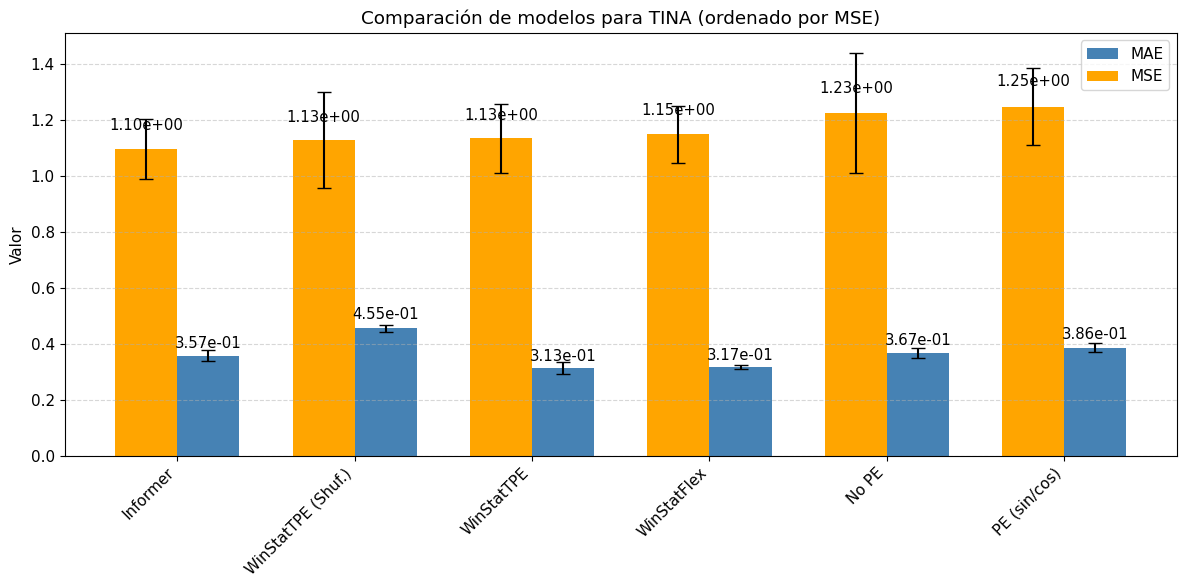

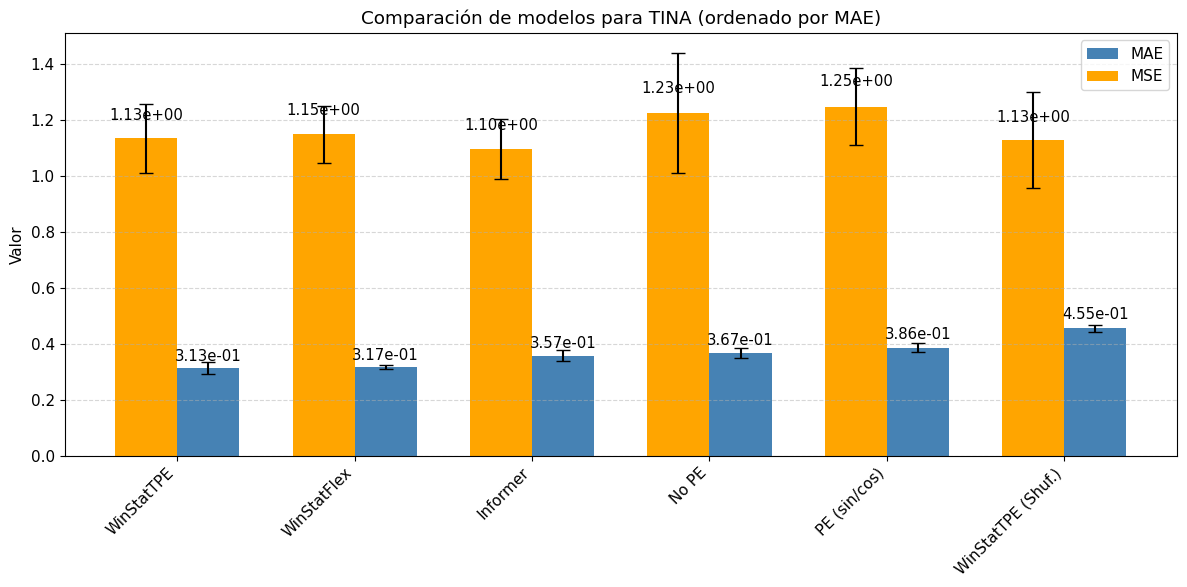

In [84]:
# Ficheros con sus nombres de modelo
model_files = {
    "WinStatFlex": "Experimentos/metricas_InformerVanilla_tina_all_pe_opt_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_all_pe_opt.csv",
    #"WinStatFlex (Shuf.)": "Experimentos/metricas_InformerVanilla_tina_all_pe_opt_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_all_pe_opt.csv",
    "Informer": "Experimentos/metricas_InformerVanilla_tina_informer_opt_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_informer_opt.csv",
    "PE (sin/cos)": "Experimentos/metricas_InformerVanilla_tina_pe_fixed_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebfixed_dtTrue_mxTrue_test_tina_pe_fixed.csv",
    #"Informer (shuffled)":"Experimentos/metricas_InformerVanilla_tina_informer_opt_shuffled_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_informer_opt_shuffled.csv",
    "No PE": "Experimentos/metricas_InformerVanilla_tina_not_pe_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_not_pe.csv",
    "WinStatTPE": "Experimentos/metricas_InformerVanilla_tina_tpe_opt_informer_TINA_ftM_sl288_ll96_pl48_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_tpe_opt.csv",
    "WinStatTPE (Shuf.)": "Experimentos/metricas_InformerVanilla_tina_tpe32_shuffled_informer_TINA_ftM_sl180_ll60_pl60_win60_dm512_nh8_el2_dl1_df2048_atfull_fc5_ebtimeF_dtTrue_mxTrue_test_tina_tpe32_shuffled.csv"
}

dfs = []

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    #print(file_path)
    df['Modelo'] = model_name  # Añadir columna del modelo

    # Pivotar valores de Mean y STD
    df_mean = df.pivot(index='Modelo', columns='Metric', values='Mean')
    df_std = df.pivot(index='Modelo', columns='Metric', values='STD')

    # Renombrar columnas para distinguir Mean y STD
    df_mean.columns = [f"{col}_Mean" for col in df_mean.columns]
    df_std.columns = [f"{col}_STD" for col in df_std.columns]

    # Combinar ambos
    df_combined = pd.concat([df_mean, df_std], axis=1)

    dfs.append(df_combined)

# Unir todos los modelos
final_df = pd.concat(dfs)

# Resetear índice y ordenar por MSE_Mean
final_df.reset_index(inplace=True)
final_df = final_df.sort_values(by="MSE_Mean")

# Mostramos tabla y gráfico
display(final_df)
plot_metricas_con_error(final_df, titulo=f"Comparación de modelos para TINA (ordenado por MSE)")
plot_metricas_con_error(final_df.sort_values(by="MAE_Mean"), titulo=f"Comparación de modelos para TINA (ordenado por MAE)")

Como puede observarse, en este caso Informer logra un rendimiento notablemente superior en comparación con el resto de métodos evaluados:

- El modelo TPE presenta un desempeño relativamente cercano, con una diferencia media en el error cuadrático medio (MSE) de apenas $10^{-2}$. No obstante, esta pequeña variación podría considerarse suficiente para afirmar que la versión original de Informer demuestra ventaja.
- Por otro lado, el modelo All_PE obtiene resultados aún más próximos a los de TPE. En este caso, logra una menor varianza, aunque la diferencia podría deberse a variabilidad estadística más que a una ventaja estructural clara del encoding.

- Tal como era esperable, la opción de no emplear ningún tipo de codificación posicional resulta ser la menos efectiva. Pero sí que es importante destacar que en este caso no se distancia tanto de las soluciones que sí incorporan información posicional, debido a que la complejidad de la serie dificulta su predicción a largo plazo y las diferencias se acortan.

Sin duda, el dato más llamativo que podemos encontrar son los resultados del modelo original de Informer, pero con mezclado en su entrada: ofrece un mejor rendimiento que el resto de modelos. Se trata de un resultado poco intuitivo, ya que romper a propósito la temporalidad de los datos parece ir en contra de lo razonable. Buscar una respuesta a este comportamiento es bastante complicado; tal vez, podría ser furto del azar, ya que el mezclado es un proceso totalmente estocástico. Pero, al ser ejecutado en varias ocasiones para hacer el promedio, esta hipótesis puede prácticamente descartarse, ya que a mayor número de ejecuciones, más nos acercamos al rendimiento real del modelo. Posiblemente, este fenómeno sea atribuible a las propiedades del conjunto de datos en sí:

- El conjunto de datos recoge gran cantidad de valores de diferentes sensores y localizaciones, las cuales han sido anonimizadas, por lo que es posible que algunas de estas propiedades fueran dependientes directamente entre sí, y provoquen redundancia que dificulte a los modelos codificados a extraer información útil.
- Que las variables no tengan un comportamiento modelable con las características dadas. Puede que dependa de factores externos ajenos a los datos recogidos, los cuales no puedan ser directamente deducibles de los datos dados, y por tanto, dificulten el modelado correcto de la serie. O bien, que directamente su comportamiento no sea modelable al seguir algún tipo de distribución aleatoria o muy ruidosa: en ese caso, mezclar podría no afectar al resultado con tanto impacto como en los conjuntos anteriores debido a que la información temporal no aporta información útil sobre el comportamiento de cada variable.


**Sin lugar a dudas, este caso requiere especial atención en la próxima reunión.**

## Resumen final

Para resumir las claves de manera muy breve, se condensan aquí las principales conclusiones que, a mi juicio, se pueden extraer de los conjuntos de datos evaluados acerca de las codificaciones:

- Cuanto mayor es la extensión de la serie, menor impacto posee la codificación empleada en los resultados. Se reducen las distancia entre los modelos con y sin codificación, e Informer comienza a no alejarse tanto de los modelos diseñados.
- En general, los dos modelos escogidos, TPE y ALL_PE (que hace uso de pesos de ponderación para cada tipo de encoding) son los que ofrecen los mejores resultados en la mayoría de casos, siendo TPE más estable numéricamente en sucesivas ejecuciones.
- Los conjuntos de mayor extensión, como TINA y PLP, ofrecen comportamiento bastante anómalos frente a los anteriores, obteniendo TINA un mejor rendimiento cuando se mezcla su entrada de contexto al decoder, y PLP imposible de ejecutar con los recursos actuales.

# Parte 2: Estudio del valor de ventana para algoritmos ALL PE y TPE

En este apartado, examinaremos el impacto del tamaño de ventana en nuestros conjuntos de datos de menor tamaño, contenidos en paper original de Informer. El objetivo consiste en ver si existe alguna relación con los valores de ventana probados con la longitud de secuencia del experimento, de forma que podamos establecer intervalos adecuados para datasets de mayor tamaño que no permitan evaluar una búsqueda de parámetros exhaustiva. El efecto deseable que se desea encontrar es algún tipo de regla heurística que nos permita realacionar ambos valores, para lo cual, tendremos que evaluar diversos datasets de longitud breve que puedan entrenarse con diferentes tamaños y con cierta garantía estadística, realizando varias ejecuciones para cada prueba.


Los datasets escogidos son los empleados en el paper original de Informer (https://arxiv.org/abs/2012.07436): ETTh1, ETTh2, ETTm1, Weather y ECL, con la incorporación de ETTm2, el cual podemos encontrar en los archivos del repositorio pero no fue utilizado en las pruebas experimentales de Informer por algún motivo que se desconoce. Por tanto, resulta interesante probar su desempeño con la alternativa propuesta.

El escenario de pruebas escogido cumple las siguientes características:

- El tamaño de secuencia es el recomendado por las ejecuciones realizadas en el paper de Informer, siguiendo la estructura de la tabla. Por ejemplo, en el caso de ETTh, el tamaño de secuencia de 96, token de contexto de 48, y longitud de predicción de 24.
- Las pruebas se realizan 10 veces por tamaño de ventana, de manera que exista estabilidad numérica en los resultados y la curva muestre un comportamiento más cercano al real, tratando de suavizar efectos provocados por ruido.
- Los modelos evaluados son ALL_PE y TPE, ya que son los que mayor rendimiento exhibieron en las pruebas realizadas sobre datasets de mayor tamaño, y ambos requieren de un ajuste de ese parámetro.



In [85]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

A continuación, podemos encontrar el código empleado para la representación de los datos. Se procede a realizar la lectura de los ficheros asociados a cada tipo de ventana y algoritmo de los mencionados, y se procede a realizar un gráfico que muestre el comportamiento de cada algoritmo con respecto al tamaño de ventana y el error cuadrático medio.

In [97]:
def extract_mse_from_csv(filepath):
    """Extrae el valor de MSE (Mean) desde un archivo CSV."""
    df = pd.read_csv(filepath)
    row = df[df['Metric'] == 'MSE']
    if not row.empty:
        return float(row['Mean'].values[0])
    return None


def collect_mse_by_window(dataset, log_folder, start_window, end_window):
    """Recoge los valores MSE por tamaño de ventana para all_pe_weighted y tpe."""
    results_pe, results_tpe = {}, {}

    for window in range(start_window, end_window + 1):
        pe_pattern = os.path.join(
            log_folder, f"{dataset}_ALL_PE", f"*win{window}*.csv")
        tpe_pattern = os.path.join(
            log_folder, f"{dataset}_TPE", f"*win{window}*.csv")

        pe_files = glob.glob(pe_pattern)
        tpe_files = glob.glob(tpe_pattern)

        if pe_files:
            mse_pe = extract_mse_from_csv(pe_files[0])
            if mse_pe is not None:
                results_pe[window] = mse_pe

        if tpe_files:
            mse_tpe = extract_mse_from_csv(tpe_files[0])
            if mse_tpe is not None:
                results_tpe[window] = mse_tpe

    return dict(sorted(results_pe.items())), dict(sorted(results_tpe.items()))


def collect_mse_by_windowonly(dataset, log_folder, start_window, end_window):
    """Recoge los valores MSE por tamaño de ventana para stats y stats_lags."""
    results_pe, results_tpe = {}, {}

    for window in range(start_window, end_window + 1):
        pe_pattern = os.path.join(
            log_folder, f"{dataset}_Stats", f"*win{window}*.csv")
        tpe_pattern = os.path.join(
            log_folder, f"{dataset}_StatLags", f"*win{window}*.csv")

        pe_files = glob.glob(pe_pattern)
        tpe_files = glob.glob(tpe_pattern)

        if pe_files:
            mse_pe = extract_mse_from_csv(pe_files[0])
            if mse_pe is not None:
                results_pe[window] = mse_pe

        if tpe_files:
            mse_tpe = extract_mse_from_csv(tpe_files[0])
            if mse_tpe is not None:
                results_tpe[window] = mse_tpe

    return dict(sorted(results_pe.items())), dict(sorted(results_tpe.items()))


def print_top_results(data, label, top_n=5):
    """Imprime los top N resultados con menor MSE."""
    print(f"\nTop {top_n} resultados para {label}:")
    sorted_items = sorted(data.items(), key=lambda x: x[1])
    for i, (window, mse) in enumerate(sorted_items[:top_n], 1):
        print(f"{i}. Window: {window} - MSE: {mse:.6f}")


def annotate_top_points(x, y, top_n, label_color):
    """Anota los top N puntos mínimos en la curva."""
    sorted_points = sorted(zip(x, y), key=lambda x: x[1])[:top_n]
    for win, val in sorted_points:
        plt.annotate(f"{win}", xy=(win, val), xytext=(win, val + 0.05),
                     ha='center', fontsize=12, fontweight='bold', color=label_color,
                     arrowprops=dict(arrowstyle='->', color=label_color, lw=0.8))


def plot_curvas_mse(pe_data, tpe_data, dataset, top_n=5):
    """Grafica las curvas de MSE para PE y TPE, con anotaciones."""
    x_pe = list(pe_data.keys())
    y_pe = list(pe_data.values())
    x_tpe = list(tpe_data.keys())
    y_tpe = list(tpe_data.values())

    plt.figure(figsize=(10, 6))
    plt.plot(x_pe, y_pe, label="all_pe_weighted", marker="o")
    plt.plot(x_tpe, y_tpe, label="tpe", marker="s")

    annotate_top_points(x_pe, y_pe, top_n=top_n, label_color="blue")
    annotate_top_points(x_tpe, y_tpe, top_n=top_n, label_color="green")

    plt.xlabel("Window Size")
    plt.ylabel("Mean MSE")
    plt.title(f"Mean MSE vs Window Size ({dataset})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f"mean_mse_vs_window_{dataset}.png")
    plt.show()


def plot_curvas_mseVentana(pe_data, tpe_data, dataset, top_n=5):
    """Grafica las curvas de MSE para PE y TPE, con anotaciones."""
    x_pe = list(pe_data.keys())
    y_pe = list(pe_data.values())
    x_tpe = list(tpe_data.keys())
    y_tpe = list(tpe_data.values())

    plt.figure(figsize=(10, 6))
    #plt.plot(x_pe, y_pe, label="stats", marker="o")
    plt.plot(x_tpe, y_tpe, label="WinStatLag", marker="s", color="steelblue")

    #annotate_top_points(x_pe, y_pe, top_n=top_n, label_color="blue")
    annotate_top_points(x_tpe, y_tpe, top_n=top_n, label_color="black")

    plt.xlabel("Window Size")
    plt.ylabel("Mean MSE")
    plt.title(f"Mean MSE vs Window Size ({dataset})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"mean_mse_vs_window_{dataset}.png")
    plt.show()

## ETTh1

En primer lugar, volveremos a evaluar el primer dataset asociado a timestamps horarios, que ya probamos en el apartado anterior, para estudiar cuál es valor ideal del tamaño de ventana. Usando un tamaño de ventana de mínimo 3, y un máximo de hasta 96, coincidiendo con la longitud de secuencia.

- Longitud de secuencia: 96
- Longitud de token de contexto: 48
- Longitud de predicción: 24

Podemos obtener los resultados que se aprecian en el siguiente gráfico:

Para la variante basada únicamente en Ventanas:

In [87]:
DATASET = "ETTh1"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (4, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_windowonly(DATASET, LOG_FOLDER, start, end)
#plot_curvas_mseVentana(results_pe, results_tpe, DATASET)

Para TPE y all:

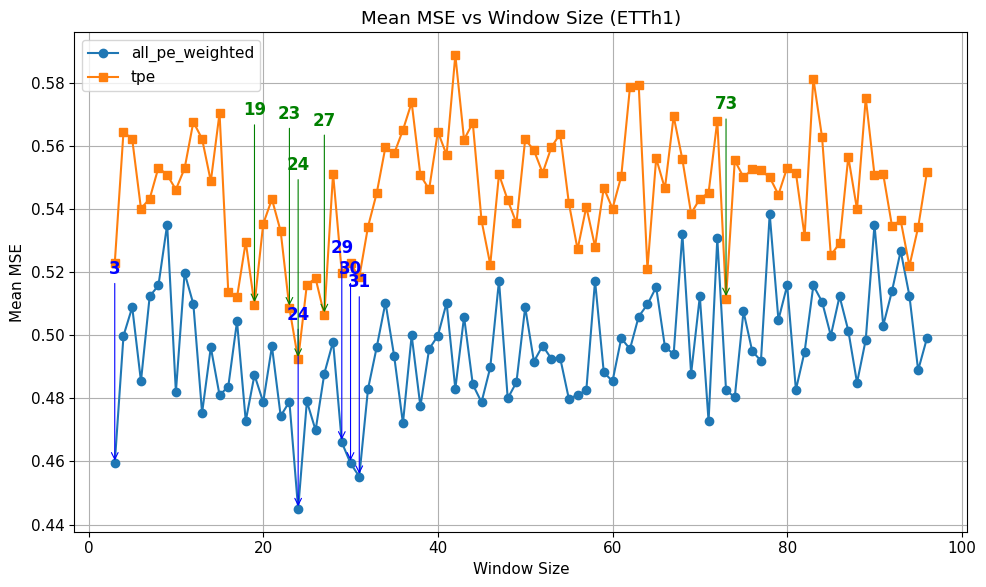

In [88]:

DATASET = "ETTh1"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (3, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_window(DATASET, LOG_FOLDER, start, end)
plot_curvas_mse(results_pe, results_tpe, DATASET)

Podemos apreciar que ambos algoritmos sufren un comportamiento bastante irregular, y cercanos entorno a un valor medio concreto: sobre 0.54  en el caso de TPE, y 0.48 en el caso de ALL_PE. Sin embargo, aunque su tendencia es bastante plana, podemos apreciar que si existe una mejora razonable en los resultados cuando nos acercamos al entorno de valores entre el 24-30. En ese intervalo, se ubican los 5 mejores resultados de ambos algoritmos (a expcepción del tamaño 73 para TPE, pero podría ser un punto ruidoso).

Esto podría indicarnos que un valor dentro de dicho intervalo nos permite mejorar los resultados. En ambos casos, resulta bastante evidente que el 24 parece ser el "número mágico" que estábamos buscando. Curiosamente, se trata exactamente de un cuarto del valor de longitud de secuencia, ya que: $$96\%4 = 0$$

Por lo tanto, podríamos extraer a priori una heurística que nos indica que escoger como tamaño de ventana 1/4 de la longitud de secuencia parece razonable.

## ETTh2

Una vez evaluada la primera variante, es turno de ejecutar ETTh2. Al tener características similares a la primera, usaremos exactamente los mismos parámetros:
- Longitud de secuencia: 96
- Longitud de token de contexto: 48
- Longitud de predicción: 24

Las condiciones de los valores probados son los mismos: desde tamaño 3 hasta 96, coincidiendo con el tamaño de secuencia.

In [89]:
DATASET = "ETTh2"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (4, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_windowonly(DATASET, LOG_FOLDER, start, end)
#plot_curvas_mseVentana(results_pe, results_tpe, DATASET)

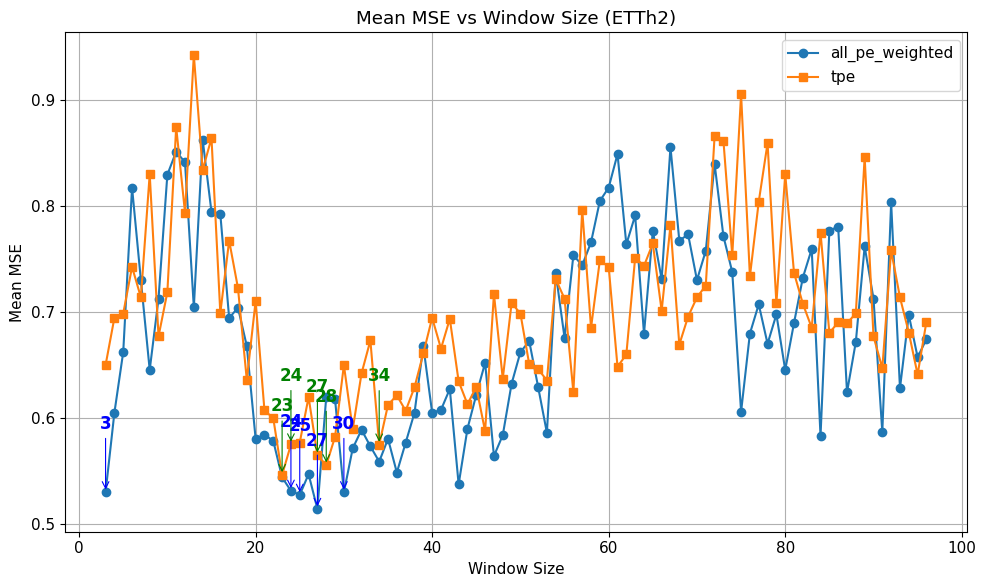

In [90]:

DATASET = "ETTh2"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (3, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_window(DATASET, LOG_FOLDER, start, end)
plot_curvas_mse(results_pe, results_tpe, DATASET)

Observando la gráfica anterior, podemos ver que en este caso, las distancias entre ambos algoritmos es menor, ofreciendo un resultado similar. Pero los más interesante se puede observar en la forma de las curvas; el comportamiento es bastante más sencillo de interpretar que el caso anterior, e indica grandes ganancias en rendimiento de MSE de nuevo en el entorno de valores de 23 a 30 para ambos algoritmos.

Esto refuerza nuestra hipótesis del 1/4 de manera bastante contundente, pero a continuación, tendremos que probar en datasets de mayor granularidad.

## ETTm1

Ahora, procedemos a realizar la misma ejecución pero empleando la versión minuto a minuto del primer transformador.

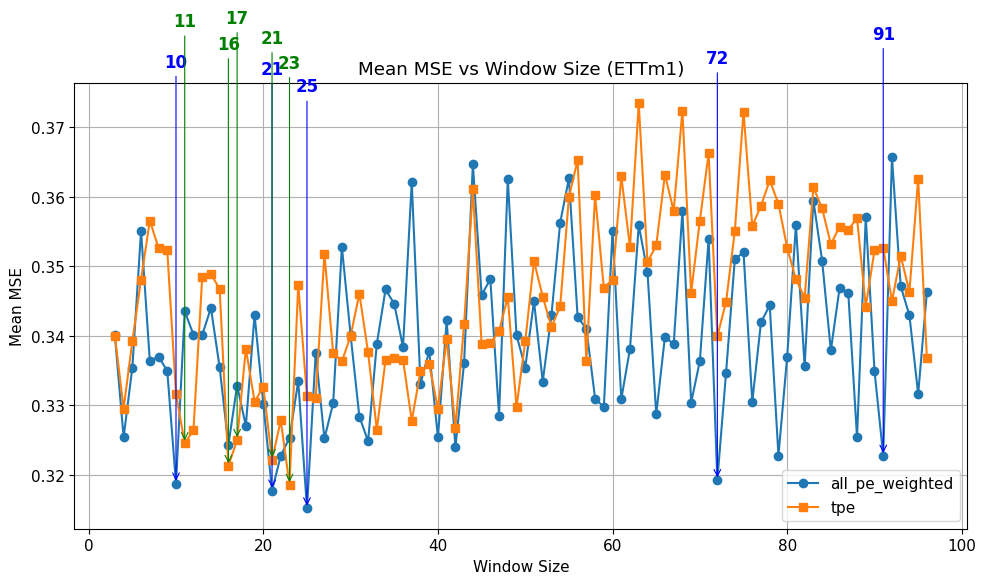

In [96]:

DATASET = "ETTm1"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (3, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_window(DATASET, LOG_FOLDER, start, end)
plot_curvas_mse(results_pe, results_tpe, DATASET)

De nuevo, encontramos un patrón similar a la serie sampleada por horas, pero con una ligera tendencia a menores tamaños de ventana. Aun así, los valores cercanos a 1/4, es decir, 24, siguen incluidos en el intervalo. El valor 72, curiosamente, destaca como un valor inferior, al igual que lo hizo 73 en la variante horaria. Sin embargo, es preferible escoger un valor de la región más a la izquierda, un flat minima, pues posiblemente generalizará mejor que el 72, que es un sharp minima.

## ETTm2

Aplicaremos las mismas condiciones para la variante minuto a minuto de ETT2:

- Longitud de secuencia: 96
- Longitud de token de contexto: 48
- Longitud de predicción: 24

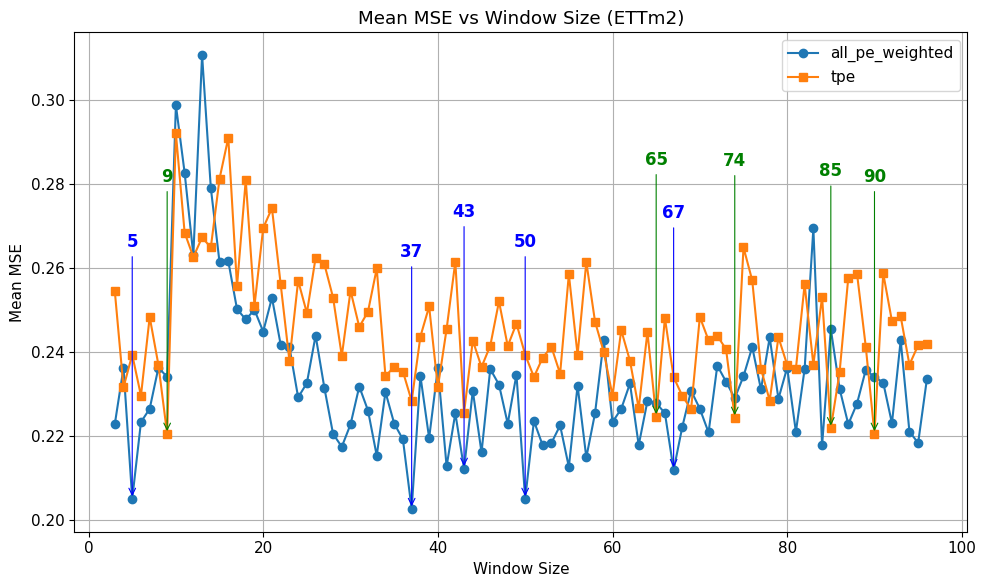

In [95]:

DATASET = "ETTm2"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (3, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_window(DATASET, LOG_FOLDER, start, end)
plot_curvas_mse(results_pe, results_tpe, DATASET)

El comportamiento arrojado por este dataset es bastante diferente a los anteriores. Si analizamos gráficamente su comportamiento (como ya se hizo en la memoria del TFM), podemos apreciar que la tendencia seguida por esta serie temporal siempre ha sido diferente a las otras 3, e incluso fue descartado su uso en la paper original de Informer. Si observamos, los valores destacados con un mayor rendimiento tienden a distribuirse de manera prácticamente uniforme en la mitad derecha de la gráfica, no modificando drásticamente su comportamiento, si bien parece que comienza una ligera tendencia de empeoramiento a partir del valor 80.

Debido a este extraño comportamiento, en este dataset no podríamos aplicar la regla del cuarto, ya que potencialmente fomentada por una mayor complejidad, esta serie se beneficia de tamaños de ventana mayores. Para no escoger un valor demasiado grande, considero que en este caso el valor central, 48, sería más que suficiente, ya que se trata de un valor intermedio entre todos los valores emergentes.

## Weather Dataset

A continuación, se muestra el mismo experimento para el dataset Weather

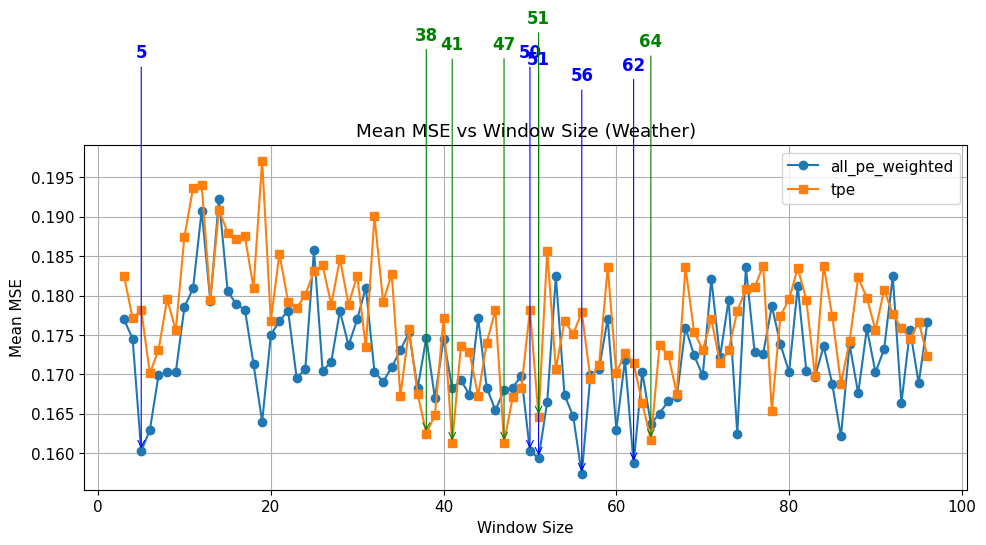

In [98]:

DATASET = "Weather"
LOG_FOLDER = "Experimentos/EstudioVentana"
WINDOW_RANGE = (3, 96)


start, end = WINDOW_RANGE
results_pe, results_tpe = collect_mse_by_window(DATASET, LOG_FOLDER, start, end)
plot_curvas_mse(results_pe, results_tpe, DATASET)